# Patch Level WSI Fine Registration Demo Notebook

This notebook demonstrates the complete workflow for Whole Slide Image (WSI) registration using rigid and non-rigid techniques with nuclei-based analysis.

## Overview
- **Rigid Registration**: Initial coarse alignment using traditional techniques

## 1. Setup and Imports

In [1]:
import sys
import os

# Add project root to PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # adjust if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
# Enable inline plotting and auto-reload for development
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import all necessary modules
import SimpleITK as sitk 
from wsi_mif_registration.utils.imports import *
from wsi_mif_registration.config import *
from wsi_mif_registration.preprocessing.preprocessing import *
from wsi_mif_registration.preprocessing.padding import *
from wsi_mif_registration.registration.registration import *
from wsi_mif_registration.registration.nonrigid import *
from wsi_mif_registration.evaluation.evaluation import *
from wsi_mif_registration.visualization.visualization import *
from wsi_mif_registration.preprocessing.nuclei_analysis import *

# Setup Bokeh for notebook output
setup_bokeh_notebook()

print("✅ All modules imported successfully!")
print(f"Source WSI: {SOURCE_WSI_PATH}")
print(f"Target WSI: {TARGET_WSI_PATH}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


|2025-06-09|11:33:31.073| [WARNING] /home/u5552013/miniconda3/envs/tiatoolbox-reg-vis/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



Loading BokehJS ...

✅ All modules imported successfully!
Source WSI: /home/u5552013/Desktop/RegistrationDataset/HyReCo/KI67/533.tif
Target WSI: /home/u5552013/Desktop/RegistrationDataset/HyReCo/HE/533.tif


## 2. Configuration Check

Verify that all file paths are correct and files exist.

In [3]:
import os

# Check if files exist
files_to_check = [
    SOURCE_WSI_PATH,
    TARGET_WSI_PATH,
    FIXED_POINTS_PATH,
    MOVING_POINTS_PATH
]

print("File existence check:")
for file_path in files_to_check:
    exists = os.path.exists(file_path)
    status = "✅" if exists else "❌"
    print(f"{status} {file_path}")

# Display current parameters
print("\nCurrent Parameters:")
print(f"- Preprocessing Resolution: {PREPROCESSING_RESOLUTION}")
print(f"- Registration Resolution: {REGISTRATION_RESOLUTION}")
print(f"- Patch Size: {PATCH_SIZE}")
print(f"- Fixed Threshold: {FIXED_THRESHOLD}")
print(f"- Moving Threshold: {MOVING_THRESHOLD}")
print(f"- Min Nuclei Area: {MIN_NUCLEI_AREA}")

File existence check:
✅ /home/u5552013/Desktop/RegistrationDataset/HyReCo/KI67/533.tif
✅ /home/u5552013/Desktop/RegistrationDataset/HyReCo/HE/533.tif
✅ /home/u5552013/Desktop/RegistrationDataset/HyReCo/HE/533.csv
✅ /home/u5552013/Desktop/RegistrationDataset/HyReCo/KI67/533.csv

Current Parameters:
- Preprocessing Resolution: 0.625
- Registration Resolution: 40
- Patch Size: (1000, 1000)
- Fixed Threshold: 100
- Moving Threshold: 50
- Min Nuclei Area: 200


## 3. Load and Preprocess WSI Images

In [4]:
# Load WSI images
print("Loading WSI images...")
source_wsi, target_wsi, source, target = load_wsi_images(
    SOURCE_WSI_PATH, TARGET_WSI_PATH, PREPROCESSING_RESOLUTION
)

print(f"\nLoaded images:")
print(f"Source shape: {source.shape}")
print(f"Target shape: {target.shape}")

|2025-06-09|11:33:38.974| [ERROR] File does not have a .json extension.


Loading WSI images...


|2025-06-09|11:33:39.585| [ERROR] File does not have a .json extension.
|2025-06-09|11:33:40.021| [ERROR] File does not have a .json extension.
|2025-06-09|11:33:40.390| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).
|2025-06-09|11:33:40.393| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2025-06-09|11:33:41.077| [ERROR] File does not have a .json extension.
|2025-06-09|11:33:41.491| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).
|2025-06-09|11:33:41.492| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


Source original shape: (3451, 1520, 3)
Target original shape: (3450, 1520, 3)

Loaded images:
Source shape: (3451, 1520, 3)
Target shape: (3450, 1520, 3)


In [5]:
# Preprocess images
print("Preprocessing images...")
# source_prep, target_prep = preprocess_images(source, target)
source_prep,target_prep, padding_params=pad_images(source, target)
# Extract tissue masks
print("Extracting tissue masks...")
source_mask, target_mask = extract_tissue_masks(source_prep, target_prep)

print("✅ Preprocessing completed!")

Preprocessing images...
Extracting tissue masks...
✅ Preprocessing completed!


## 4. Visualize Original Images and Tissue Masks

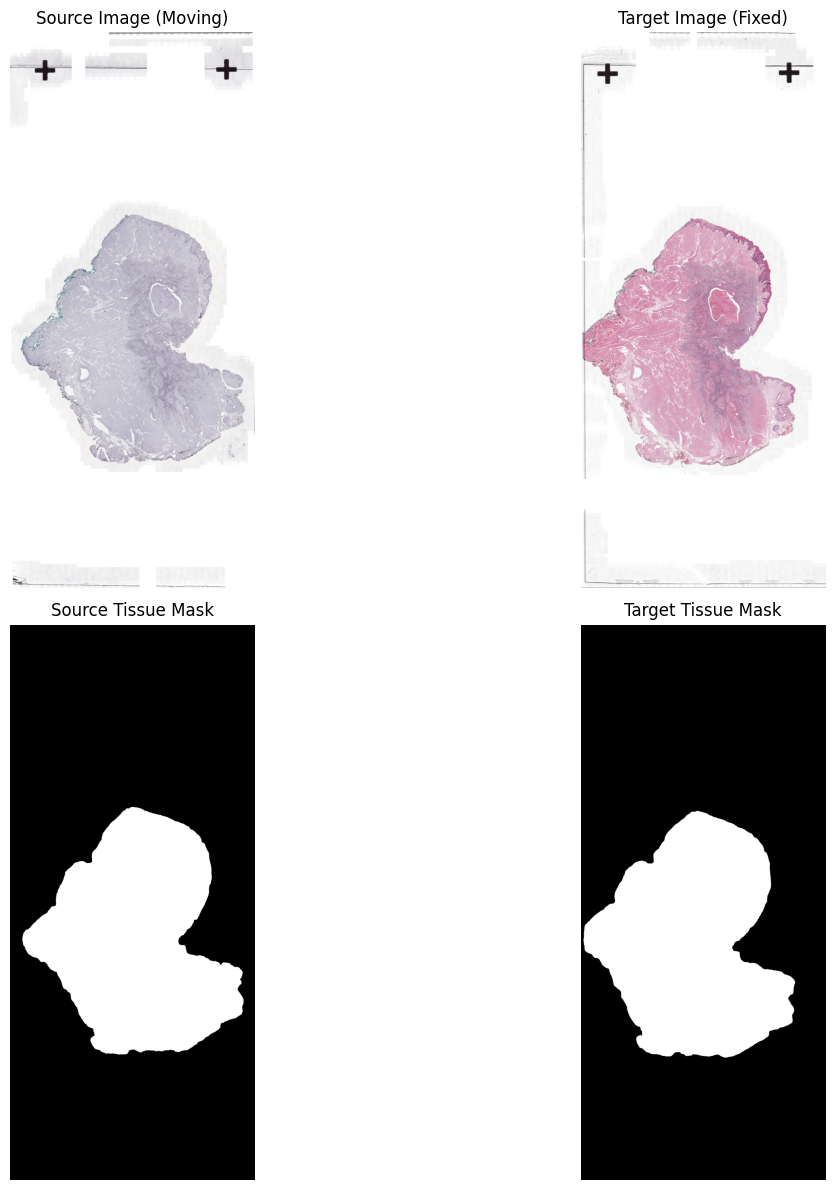

In [6]:
# Display original images side by side
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(source_prep)
axes[0, 0].set_title('Source Image (Moving)')
axes[0, 0].axis('off')

axes[0, 1].imshow(target_prep)
axes[0, 1].set_title('Target Image (Fixed)')
axes[0, 1].axis('off')

axes[1, 0].imshow(source_mask, cmap='gray')
axes[1, 0].set_title('Source Tissue Mask')
axes[1, 0].axis('off')

axes[1, 1].imshow(target_mask, cmap='gray')
axes[1, 1].set_title('Target Tissue Mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 5. Perform Rigid Registration

Performing rigid registration...


|2025-06-09|11:33:56.385| [WARNING] /home/u5552013/Desktop/WSI_mIF_Registration/accelerated_features/modules/xfeat.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.

ngf 0.03852772267620144
loading weights from: /home/u5552013/Desktop/WSI_mIF_Registration/accelerated_features/modules/../weights/xfeat.pt
ngf 0.041983008746818824
ngf 0.04672027149112584

Rigid transformation matrix:
[[  0.99539452  -0.07569868  51.68875352]
 [  0.07569868   0.99539452 -30.64145523]
 [  0.           0.           1.        ]]


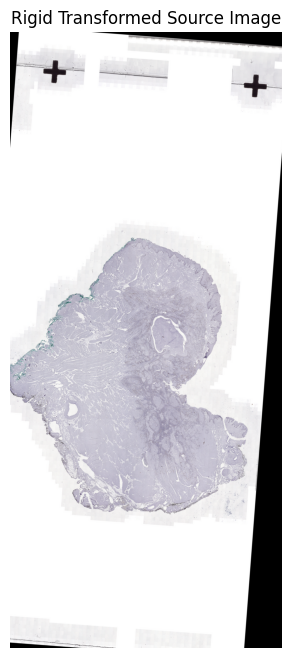

✅ Rigid registration completed!


In [7]:
# Perform rigid registration
print("Performing rigid registration...")
moving_img_transformed, final_transform = perform_rigid_registration(
    source_prep, target_prep, source_mask, target_mask
)

print("\nRigid transformation matrix:")
print(final_transform)

# Visualize transformed image
plt.figure(figsize=(12, 8))
plt.imshow(moving_img_transformed)
plt.title('Rigid Transformed Source Image')
plt.axis('off')
plt.show()

print("✅ Rigid registration completed!")

In [ ]:
u_x, u_y = util.rigid_dot(source_prep, np.linalg.inv(final_transform))

deformation_field = np.stack(( u_x, u_y), axis=-1)
sitk_image = sitk.GetImageFromArray(deformation_field)
# sitk.WriteImage(sitk_image, '/home/u5552013/Nextcloud/HYRECO_VIS/overlays/464_rigid.mha')

## 6. Non Rigid Registration

In [8]:
displacement_field,warped_source= elastic_image_registration(
   moving_img_transformed,
   target_prep,
    similarity_metric_params={'win_size': 7}, 
     compute_device='cuda'  # Use the same device
)
print("non rigid displacement field",displacement_field.shape)

|2025-06-09|11:34:01.949| [INFO] Using device: cuda


|2025-06-09|11:34:02.049| [WARNING] /home/u5552013/Desktop/WSI_mIF_Registration/wsi_mif_registration/registration/nonrigid.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_tensor = t.tensor(tensor_source, dtype=t.float32, requires_grad=True).to(compute_device)

|2025-06-09|11:34:02.050| [WARNING] /home/u5552013/Desktop/WSI_mIF_Registration/wsi_mif_registration/registration/nonrigid.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = t.tensor(tensor_target, dtype=t.float32, requires_grad=True).to(compute_device)



|2025-06-09|11:34:02.153| [INFO] Moving image tensor size: torch.Size([1, 1, 3451, 1520])
|2025-06-09|11:34:02.153| [INFO] Creating 7-level image pyramids
|2025-06-09|11:34:02.183| [INFO] Starting level 0/6 - Resolution: 53x23
|2025-06-09|11:34:02.184| [INFO] Initializing zero displacement field
|2025-06-09|11:34:02.725| [INFO] Starting level 1/6 - Resolution: 107x47
|2025-06-09|11:34:02.726| [INFO] Upscaling deformation field to 107x47
|2025-06-09|11:34:03.169| [INFO] Starting level 2/6 - Resolution: 215x95
|2025-06-09|11:34:03.169| [INFO] Upscaling deformation field to 215x95
|2025-06-09|11:34:03.621| [INFO] Starting level 3/6 - Resolution: 431x190
|2025-06-09|11:34:03.621| [INFO] Upscaling deformation field to 431x190
|2025-06-09|11:34:04.095| [INFO] Starting level 4/6 - Resolution: 862x380
|2025-06-09|11:34:04.096| [INFO] Upscaling deformation field to 862x380
|2025-06-09|11:34:05.150| [INFO] Starting level 5/6 - Resolution: 1725x760
|2025-06-09|11:34:05.151| [INFO] Upscaling defor

In [ ]:
disp_field_np=util.tc_df_to_np_df(displacement_field)
w_x,w_y=util.compose_vector_fields(u_x, u_y, disp_field_np[0], disp_field_np[1])

deformation_field = np.stack(( w_x, w_y), axis=-1)
sitk_image = sitk.GetImageFromArray(deformation_field)
sitk.WriteImage(sitk_image, '/home/u5552013/Nextcloud/HYRECO_VIS/overlays/31_nonrigid.mha')

## 7. Visualization

In [ ]:
%%bash 
tiatoolbox visualize --slides "/home/u5552013/Nextcloud/HYRECO_VIS/slides" --overlays "/home/u5552013/Nextcloud/HYRECO_VIS/overlays"


## 8. Scale Transformation and Extract Patches

In [9]:
# Scale transformation for high resolution analysis
transform_40x = scale_transformation_matrix(
    final_transform, PREPROCESSING_RESOLUTION, REGISTRATION_RESOLUTION
)

print("Scaled transformation matrix (40x):")
print(transform_40x)

# Extract patches from target WSI
print("\nExtracting patches...")
fixed_patch_extractor = extract_patches_from_wsi(
    target_wsi, target_mask, PATCH_SIZE, PATCH_STRIDE
)

print(f"Total patches extracted: {len(fixed_patch_extractor)}")

|2025-06-09|11:34:31.163| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


Scaled transformation matrix (40x):
[[ 9.95394516e-01 -7.56986785e-02  3.30808023e+03]
 [ 7.56986785e-02  9.95394516e-01 -1.96105313e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Extracting patches...
Total patches extracted: 5495


## 7. Visualize Sample Patches

Visualizing patch 100 at location (40000, 80000)


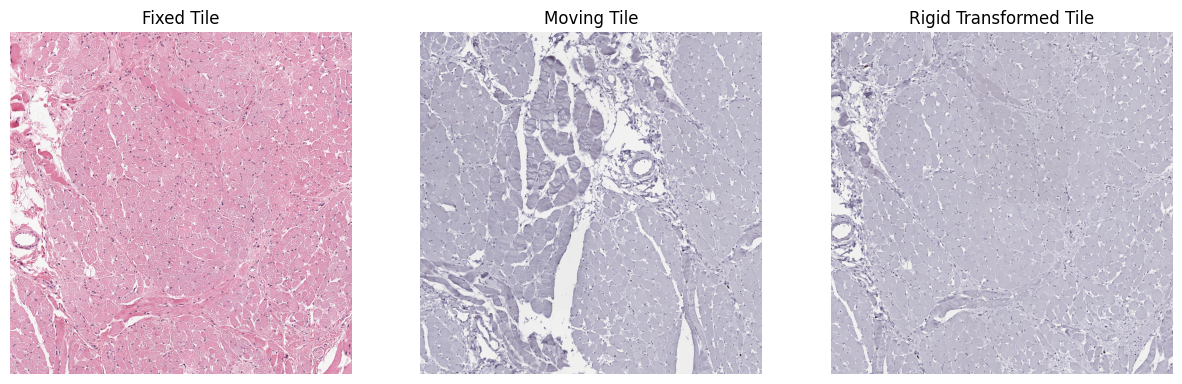

In [12]:
# Select a patch for visualization
patch_idx = 100  # You can change this index
loc = fixed_patch_extractor.coordinate_list[patch_idx]
location = (loc[0], loc[1])

print(f"Visualizing patch {patch_idx} at location {location}")

# Extract regions for comparison
fixed_tile = target_wsi.read_rect(location, VISUALIZATION_SIZE, resolution=40, units="power")
moving_tile = source_wsi.read_rect(location, VISUALIZATION_SIZE, resolution=40, units="power")

# Create transformer and extract transformed tile
tfm = AffineWSITransformer(source_wsi, transform_40x)
transformed_tile = tfm.read_rect(location=location, size=VISUALIZATION_SIZE, resolution=0, units="level")

# Visualize patches
visualize_patches(fixed_tile, moving_tile, transformed_tile)

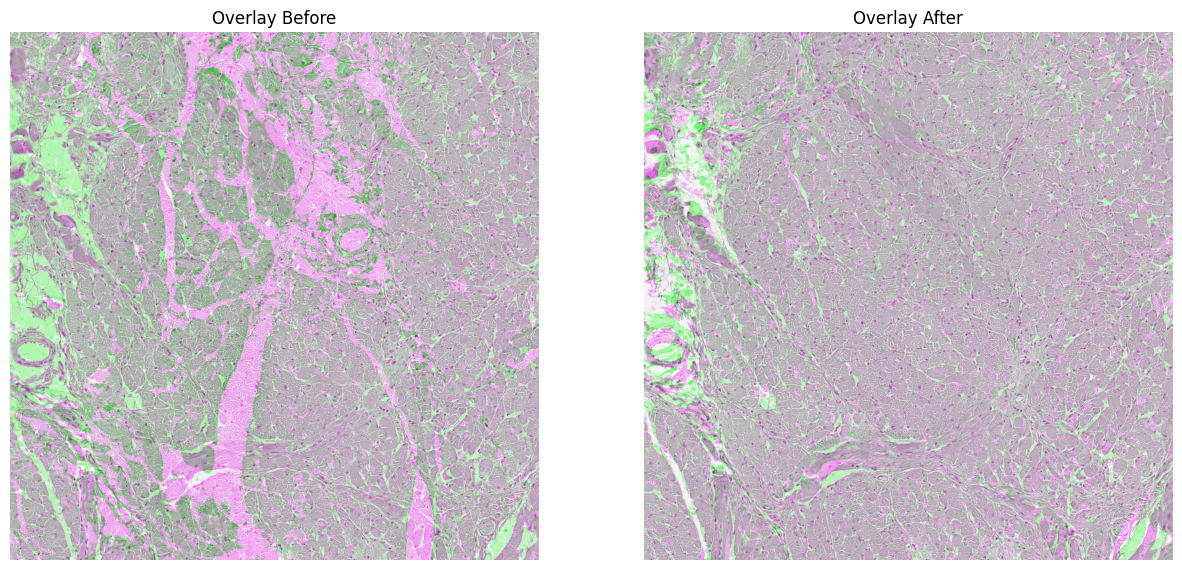

In [13]:

visualize_overlays(fixed_tile, moving_tile, transformed_tile)